In [53]:
config = {
    "path": {
        "dataset_path":"C:\\Users\\Cheon\\Dev\\deepcheese\\lob_data",
        "model_path":"C:\\Users\\Cheon\\Dev\\deepcheese\\models"
    },

    "dataset": {
        "ticker": "KQ150",
        "open": "090000",
        "close": "154500",
        "orderbook_level": 5,
        "time_window": 100,
        "price_window" : 10,
        "max_amount": 5,
        "train_ratio": 0.5,
        "val_ratio": 0.2,
        "test_ratio": 0.3,
        "predict_horizon": 100,
        "threshold": 0.0003
        #"threshold": 0.0002
    }
}

In [54]:
import os
import glob
import csv
import numpy as np
import matplotlib.pyplot as plt


_config_path = config["path"]
_config_dataset = config["dataset"]


def time_to_idx(timestring):
    hour = int(timestring[:2])
    minute = int(timestring[2:4])
    second = int(timestring[4:])
    return (hour - 9) * 60 * 60 + minute * 60 + second


def idx_to_time(idx):
    second = idx % 60
    minute = int((idx - second) / 60) % 60
    hour = (idx - second - minute * 60) // (60 * 60)
    return '%02d:%02d:%02d' % (hour + 9, minute, second)


def get_file_path(data_type, ticker, date="*"):
    match data_type:
        case "tradeprint":
            filename1 = "H0IFCNT0"
        case "orderbook":
            filename1 = "H0IFASP0"

    match ticker:
        case "KS200":
            filename2 = "101T*"
        case "KQ150":
            filename2 = "106T*"

    if date == "*":
        return os.path.join(_config_path["dataset_path"], f"{filename1}_{filename2}_{date}.csv")
    else:
        return glob.glob(os.path.join(_config_path["dataset_path"], f"{filename1}_{filename2}_{date}.csv"))[0]


def get_file_list(data_type, ticker):
    return glob.glob(get_file_path(data_type, ticker))


def get_days_list(ticker):
    def extract_days(file_list):
        day_list = []
        for filename in file_list:
            day_list.append(filename.split('.')[0].split('_')[-1])
        return day_list

    # return days which has coupled tradeprint and orderbook data
    day_list_1 = extract_days(get_file_list("tradeprint", ticker))
    day_list_2 = extract_days(get_file_list("orderbook", ticker))
    intersect_day = list(set(day_list_1) & set(day_list_2))
    intersect_day.sort()
    return intersect_day


def load_orderbook_data(filename):
    mul_fac = 10
    orderbook_level = 5

    time_data = []
    orderbook_data = []

    with open(filename, 'r', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        for idx, row in enumerate(reader):
            temp_timestamp = row[1]
            update = len(time_data) == 0 or temp_timestamp != time_data[-1]
            if (not row[2] == '0.00') and update:
                # Process orderbook data in single timestamp
                temp_orderbook_data = []
                for i in range(1, orderbook_level + 1):
                    single_level = [
                        ###################################################
                        int(float(row[1+i])*mul_fac), # price  | ask side
                        int(row[21+i]),               # volume |
                        ###################################################
                        int(float(row[6+i])*mul_fac), # price  | bid side
                        int(row[26+i])                # volume |
                        ###################################################
                    ]
                    temp_orderbook_data.append(single_level)
                time_data.append(temp_timestamp)
                orderbook_data.append(temp_orderbook_data)
    # sparse sampling
    time_data = np.array(time_data)[::1]
    orderbook_data = np.array(orderbook_data)[::1]
    return time_data, orderbook_data


In [55]:
import torch
import numpy as np


class MovingWindow:
    def __init__(self, day):
        self.day = day
        self.ticker = _config_dataset["ticker"]
        self.level = _config_dataset["orderbook_level"]
        self.T = _config_dataset["time_window"]
        self.W = _config_dataset["price_window"]
        self.max_quantity = _config_dataset["max_amount"]
        self.predict_horizon = _config_dataset["predict_horizon"]
        self.threshold = _config_dataset["threshold"]


        file_path = get_file_path("orderbook", self.ticker, day)
        self.orderbook_time, self.orderbook_data = load_orderbook_data(file_path)
        self.movingwindow = []
        self.ticks = []

        self.start_idx = max(self.T - 1, self.predict_horizon)
        self.end_idx = len(self.orderbook_data) - self.predict_horizon - 1

        self.midprice = []
        self.ask1 = []
        self.bid1 = []
        self.midprice_idx = []
        self.__fill_movingwindow__(self.orderbook_data)

        self.label = []
        self.__fill_label__()

    def __len__(self):
        return self.end_idx - self.start_idx + 1
    
    def __moving_window_shot__(self, lob, ticks, data_min, data_max):
        lob_shot = lob.copy()
        lob_shot[:, 1:4:2] = np.minimum(lob_shot[:, 1:4:2], self.max_quantity)
        lob_shot[:,3] = -lob_shot[:,3]

        for i in range(1, lob_shot.shape[0]):
            lob_shot[i, 1:4:2] = lob_shot[i-1, 1:4:2] + lob_shot[i, 1:4:2]

        ask_side = lob_shot[:, 0:2]
        bid_side = lob_shot[::-1, 2:4]

        midprice = (ask_side[0, 0] + bid_side[0, 0]) / 2
        ask1 = ask_side[0, 0]
        bid1 = bid_side[0, 0]
        midprice_idx = round(midprice - (data_min - self.W))

        moving_window_shot = np.zeros(ticks.shape)

        # bid side
        for i in range(5):
            if i == 0:
                start_idx = 0
            else:
                start_idx = bid_side[i-1, 0] - (data_min - self.W) + 1
            end_idx = bid_side[i, 0] - (data_min - self.W)
            moving_window_shot[start_idx:end_idx+1] = bid_side[i, 1]

        # ask side
        for i in range(5):
            if i == 4:
                end_idx = len(moving_window_shot)
            else:
                end_idx = ask_side[i + 1, 0] - (data_min - self.W) + 1
            start_idx = ask_side[i, 0] - (data_min - self.W)
            moving_window_shot[start_idx:end_idx+1] = ask_side[i, 1]

        return moving_window_shot, midprice, ask1, bid1, midprice_idx


    def __fill_movingwindow__(self, data):
        processed_data = []
        midprice = []
        ask1 = []
        bid1 = []
        midprice_idx = []

        data_min = np.min(data[:,:,0:3:2].flatten())
        data_max = np.max(data[:,:,0:3:2].flatten())
        ticks = np.arange(data_min - self.W, data_max + self.W + 1, 1)

        for i in range(data.shape[0]):
            lob_shot, midprice_, ask_1, bid_1, midprice_idx_ = self.__moving_window_shot__(data[i], ticks, data_min, data_max)
            processed_data.append(lob_shot)
            midprice.append(midprice_)
            ask1.append(ask_1)
            bid1.append(bid_1)
            midprice_idx.append(midprice_idx_)

        self.movingwindow = np.array(processed_data) / (self.max_quantity * 5)
        self.ticks = ticks
        self.midprice = np.array(midprice)
        self.ask1 = np.array(ask1)
        self.bid1 = np.array(bid1)
        self.midprice_idx = np.array(midprice_idx)
        

    def __fill_label__(self):
        label = np.zeros(self.end_idx - self.start_idx + 1)

        for index in range(self.end_idx - self.start_idx + 1):
            index_re = index + self.start_idx
            m_prev = np.mean(self.midprice[index_re - self.predict_horizon:index_re])
            m_next = np.mean(self.midprice[index_re + 1:index_re + self.predict_horizon + 1])
            l = (m_next - m_prev) / m_prev

            if l > self.threshold:
                tmp_label = 2
            elif l < -self.threshold:
                tmp_label = 0
            else:
                tmp_label = 1
            label[index] = tmp_label
        self.label = label
        # self.movingwindow = self.movingwindow[self.start_idx: self.end_idx + 1]
        # self.midprice_idx = self.midprice_idx[self.start_idx: self.end_idx + 1]
        # self.midprice = self.midprice[self.start_idx: self.end_idx + 1]
        # self.ask1 = self.ask1[self.start_idx: self.end_idx + 1]
        # self.bid1 = self.bid1[self.start_idx: self.end_idx + 1]

    def __getitem__(self, index):
        index_re = index + self.start_idx
        shot = self.movingwindow[index_re-self.T+1:index_re+1,
                                 self.midprice_idx[index_re]-self.W:self.midprice_idx[index_re]+self.W].T
        return np.expand_dims(shot, axis=0), self.label[index]
    
    def get_price(self):
        return self.midprice[self.start_idx:self.end_idx + 1], \
               self.ask1[self.start_idx:self.end_idx + 1], \
               self.bid1[self.start_idx:self.end_idx + 1]


In [56]:
#from multiprocessing import Pool
from ray.util.multiprocessing import Pool

class Dataset:
    def __init__(self, days):
        self.days = days
        self.day_datasets = []

        with Pool() as pool:
            self.day_datasets = pool.map(MovingWindow, self.days)


def get_datasets(verbose=False):
    days = get_days_list(_config_dataset["ticker"])

    val_length = max(round(len(days) * _config_dataset["val_ratio"]), 1)
    test_length = max(round(len(days) * _config_dataset["test_ratio"]), 1)
    train_length = len(days) - (val_length + test_length)

    train_days = days[:train_length]#[:2]
    val_days = days[train_length:train_length + val_length]#[:1]
    test_days = days[train_length + val_length:]#[:1]

    if verbose:
        print(f"% {len(train_days)} days for train ({train_days[0]} ~ {train_days[-1]})")
        print(f"% {len(val_days)} days for validation ({val_days[0]} ~ {val_days[-1]})")
        print(f"% {len(test_days)} days for test ({test_days[0]} ~ {test_days[-1]})")

    train_dataset = Dataset(train_days)
    val_dataset = Dataset(val_days)
    test_dataset = Dataset(test_days)

    return train_dataset, val_dataset, test_dataset


In [57]:
train_dataset, val_dataset, test_dataset = get_datasets(verbose=True)

% 38 days for train (2023-04-03 ~ 2023-05-26)
% 15 days for validation (2023-05-30 ~ 2023-06-21)
% 23 days for test (2023-06-22 ~ 2023-07-24)


In [58]:
test_loader = torch.utils.data.DataLoader(test_dataset.day_datasets[0], batch_size=64, shuffle=False)

In [59]:
test_dataset.day_datasets[0][2][0].shape

(1, 20, 100)

In [60]:
for data, label in test_loader:
    print(data.shape, label.shape)
    break

torch.Size([64, 1, 20, 100]) torch.Size([64])


In [61]:
def get_loader(dataset, batch_size):
    loaders = []
    for day_dataset in dataset.day_datasets:
        loaders.append(torch.utils.data.DataLoader(day_dataset, batch_size=batch_size, shuffle=True))
    return loaders

train_loader = get_loader(train_dataset, 512)
val_loader = get_loader(val_dataset, 512)
test_loader = get_loader(test_dataset, 512)

In [62]:
def get_label(dataset):
        label = []
        for day_dataset in dataset.day_datasets:
            label.append(day_dataset.label)
        label = np.concatenate(label, 0)
        return label


for dataset in [train_dataset, val_dataset, test_dataset]:
    label = get_label(dataset)
    print("% label distribution")
    for i in [0, 1, 2]:
        print(len(np.where(label == i)[0]))

% label distribution
246208
343859
250294
% label distribution
86304
153492
87580
% label distribution
146713
214710
159929


In [63]:
for day_loader in train_loader:
    for data, label in day_loader:
        print(data.shape, label.shape)
        break
    break

torch.Size([512, 1, 20, 100]) torch.Size([512])


In [64]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class LSTM(torch.nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.input_size = _config_dataset["price_window"] * 2
        self.num_layers = 1
        self.output_size = 3
        self.hidden_size = 64
        self.lstm = torch.nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc1 = torch.nn.Linear(64, 32)
        self.fc2 = torch.nn.Linear(32, self.output_size)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = x.squeeze(1)
        x = x.permute(0, 2, 1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc1(out[:, -1, :])
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_size = _config_dataset["time_window"] * _config_dataset["price_window"] * 2
        self.fc0 = torch.nn.Linear(self.input_size, 100)
        self.fc1 = torch.nn.Linear(100, 50)
        self.fc2 = torch.nn.Linear(50, 3)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = x.reshape(-1, self.input_size)
        out = self.fc0(x)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.fc1 = torch.nn.Linear(3072, 3)
        self.relu = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x):
        x = x.permute(0, 1, 3, 2)
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.conv3(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        return out

In [65]:
model = MLP().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


In [66]:
model(torch.rand((64, 1, _config_dataset["price_window"] * 2, _config_dataset["time_window"])).to(device)).shape

torch.Size([64, 3])

In [67]:
import torch
import numpy as np


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = []
    running_acc = []
    for day_loader in train_loader:
        for input, target in day_loader:
            input = input.to(device, dtype=torch.float)
            target = target.to(device, dtype=torch.int64)

            optimizer.zero_grad()
            output = model(input)
            loss = criterion(output, target)
            acc = (torch.count_nonzero(torch.argmax(output, dim=1) == target).item()
                   / target.size(0))

            loss.backward()
            optimizer.step()
            running_loss.append(loss.item())
            running_acc.append(acc)
    epoch_loss = np.mean(running_loss)
    epoch_acc = np.mean(running_acc)
    return epoch_loss, epoch_acc


def validation(model, test_loader, criterion, scheduler):
    model.eval()
    running_loss = []
    running_acc = []
    for day_loader in test_loader:
        for input, target in day_loader:
            input = input.to(device, dtype=torch.float)
            target = target.to(device, dtype=torch.int64)

            output = model(input)
            loss = criterion(output, target)
            acc = (torch.count_nonzero(torch.argmax(output, dim=1) == target).item()
                   / target.size(0))

            running_loss.append(loss.item())
            running_acc.append(acc)
    epoch_loss = np.mean(running_loss)
    epoch_acc = np.mean(running_acc)
    scheduler.step(epoch_loss)
    return epoch_loss, epoch_acc

In [68]:
epochs = 30

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, criterion)
    val_epoch_loss, val_epoch_acc = validation(model, val_loader, criterion, scheduler)

    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)
    val_loss.append(val_epoch_loss)
    val_acc.append(val_epoch_acc)

    print(f"Train Loss: {train_epoch_loss:.4f} | Train Acc: {train_epoch_acc:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}")

Epoch 1/30


Train Loss: 0.8321 | Train Acc: 0.6173
Val Loss: 0.7933 | Val Acc: 0.6467
Epoch 2/30
Train Loss: 0.8102 | Train Acc: 0.6259
Val Loss: 0.7885 | Val Acc: 0.6500
Epoch 3/30
Train Loss: 0.8089 | Train Acc: 0.6269
Val Loss: 0.7894 | Val Acc: 0.6485
Epoch 4/30
Train Loss: 0.8078 | Train Acc: 0.6272
Val Loss: 0.7883 | Val Acc: 0.6497
Epoch 5/30
Train Loss: 0.8074 | Train Acc: 0.6271
Val Loss: 0.7866 | Val Acc: 0.6511
Epoch 6/30
Train Loss: 0.8074 | Train Acc: 0.6270
Val Loss: 0.7866 | Val Acc: 0.6508
Epoch 7/30


KeyboardInterrupt: 

In [69]:
example_day = test_dataset.day_datasets[-2]

midprice, ask1, bid1 = example_day.get_price()

In [70]:
example_loader = torch.utils.data.DataLoader(example_day, batch_size=512, shuffle=False)

pred = []
conf = []
for input, target in example_loader:
    input = input.to(device, dtype=torch.float)
    target = target.to(device, dtype=torch.int64)

    output = model(input)
    temp_pred = torch.argmax(output, dim=1).cpu().detach().numpy()
    temp_conf = np.max(torch.nn.functional.softmax(output, dim=1).cpu().detach().numpy(), axis=1)
    pred.append(temp_pred)
    conf.append(temp_conf)
pred = np.concatenate(pred, 0)
conf = np.concatenate(conf, 0)

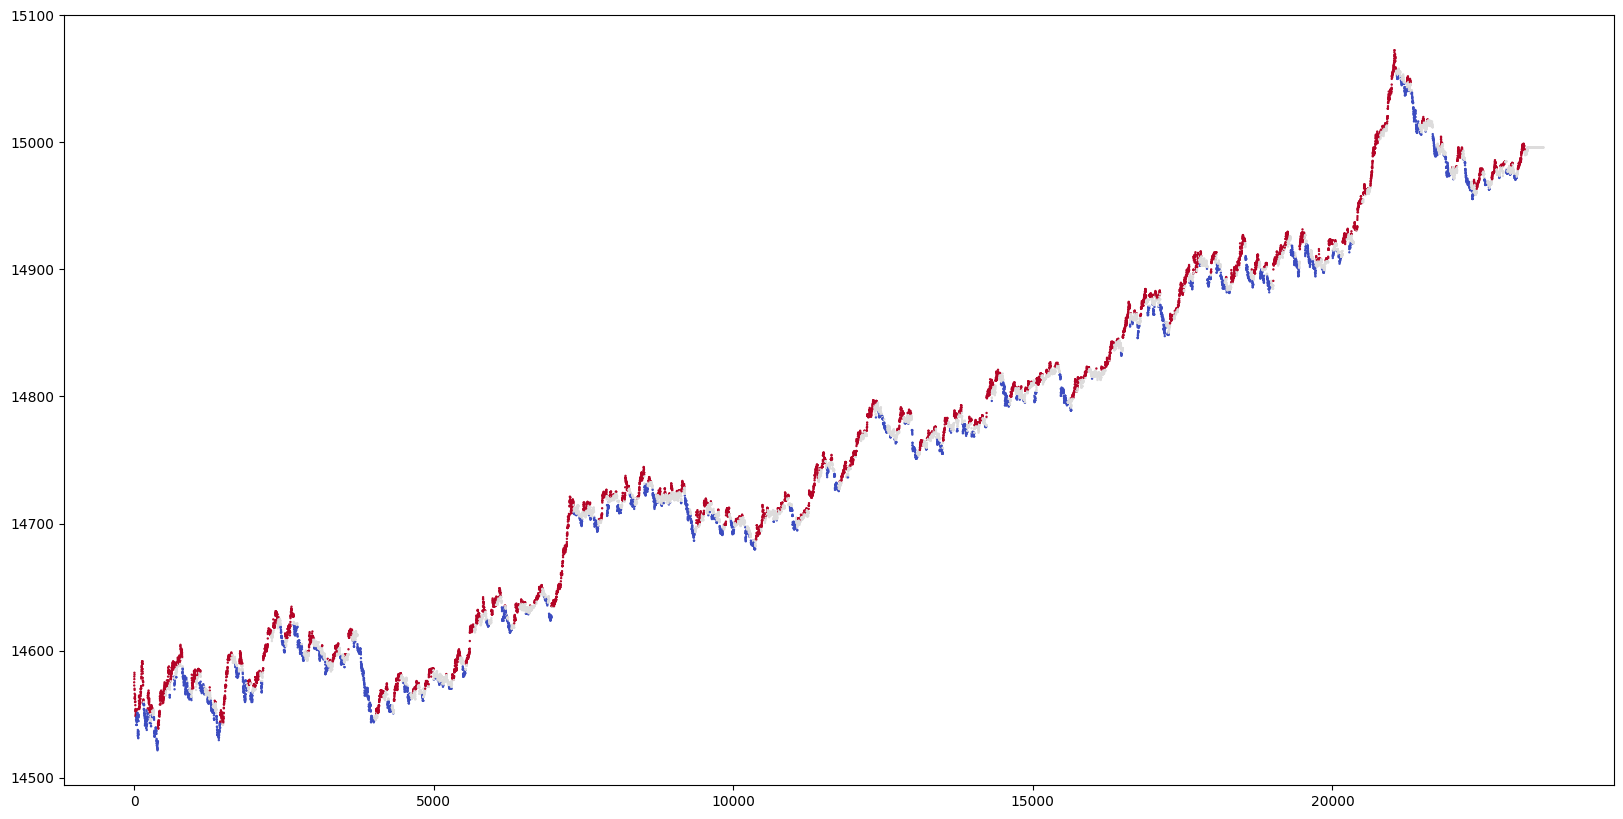

In [71]:
plt.figure(figsize=(20, 10))
plt.scatter(np.arange(len(midprice)), midprice, s=0.5, c=pred, cmap='coolwarm')

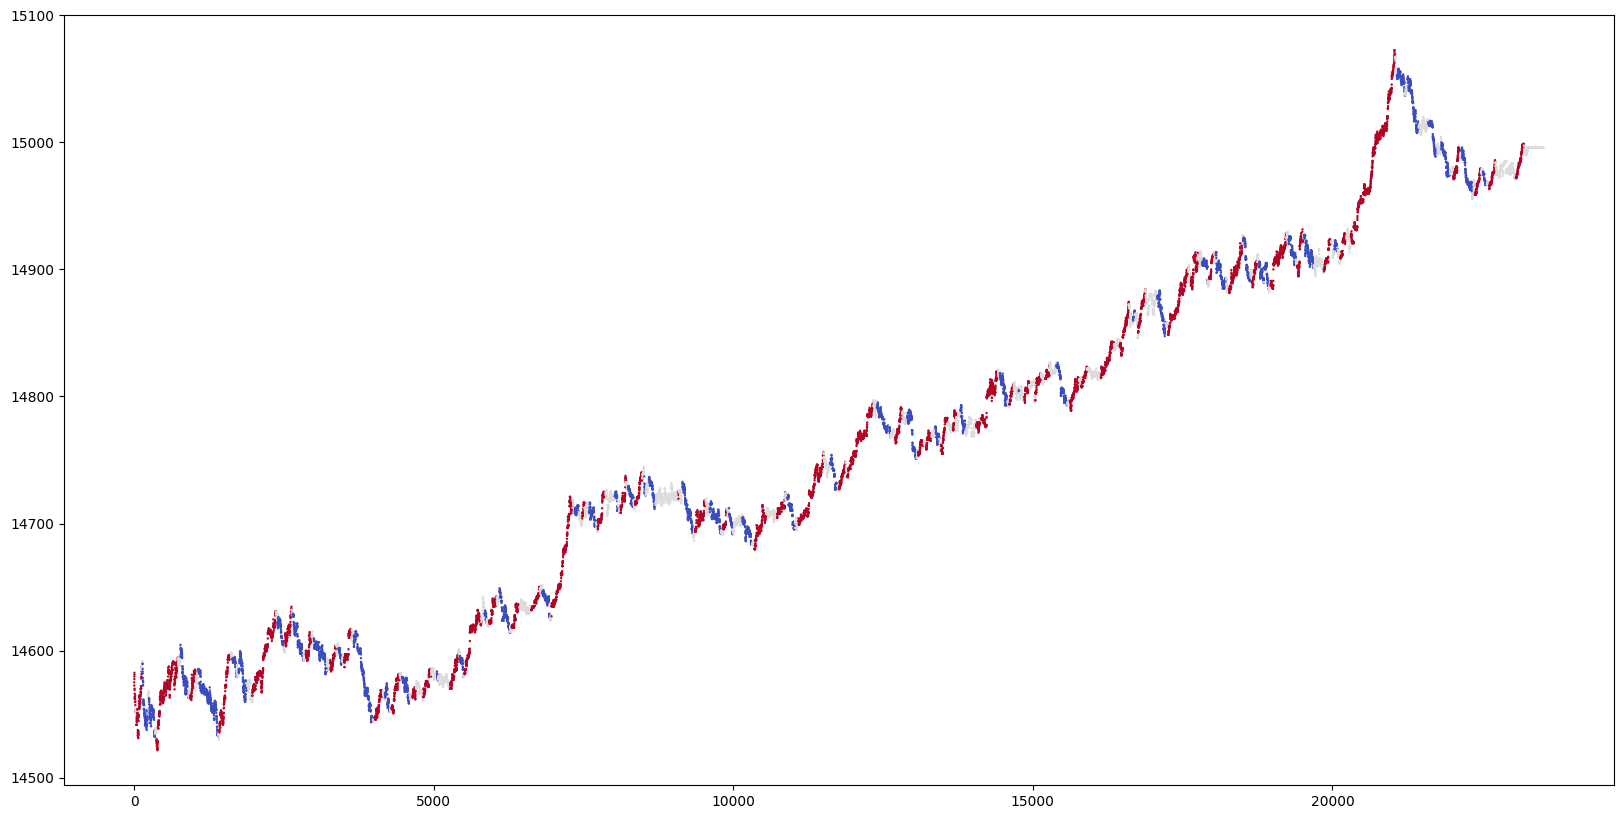

In [72]:
plt.figure(figsize=(20, 10))
plt.scatter(np.arange(len(midprice)), midprice, s=0.5, c=example_day.label, cmap='coolwarm')

In [73]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print(accuracy_score(example_day.label, pred))
print(classification_report(example_day.label, pred))
print(confusion_matrix(example_day.label, pred, normalize='true'))

0.6044385867947791
              precision    recall  f1-score   support

         0.0       0.65      0.55      0.59      6425
         1.0       0.45      0.55      0.50      7473
         2.0       0.73      0.69      0.71      9623

    accuracy                           0.60     23521
   macro avg       0.61      0.59      0.60     23521
weighted avg       0.62      0.60      0.61     23521

[[0.54645914 0.37136187 0.08217899]
 [0.19657433 0.54716981 0.25625585]
 [0.04561987 0.26675673 0.6876234 ]]


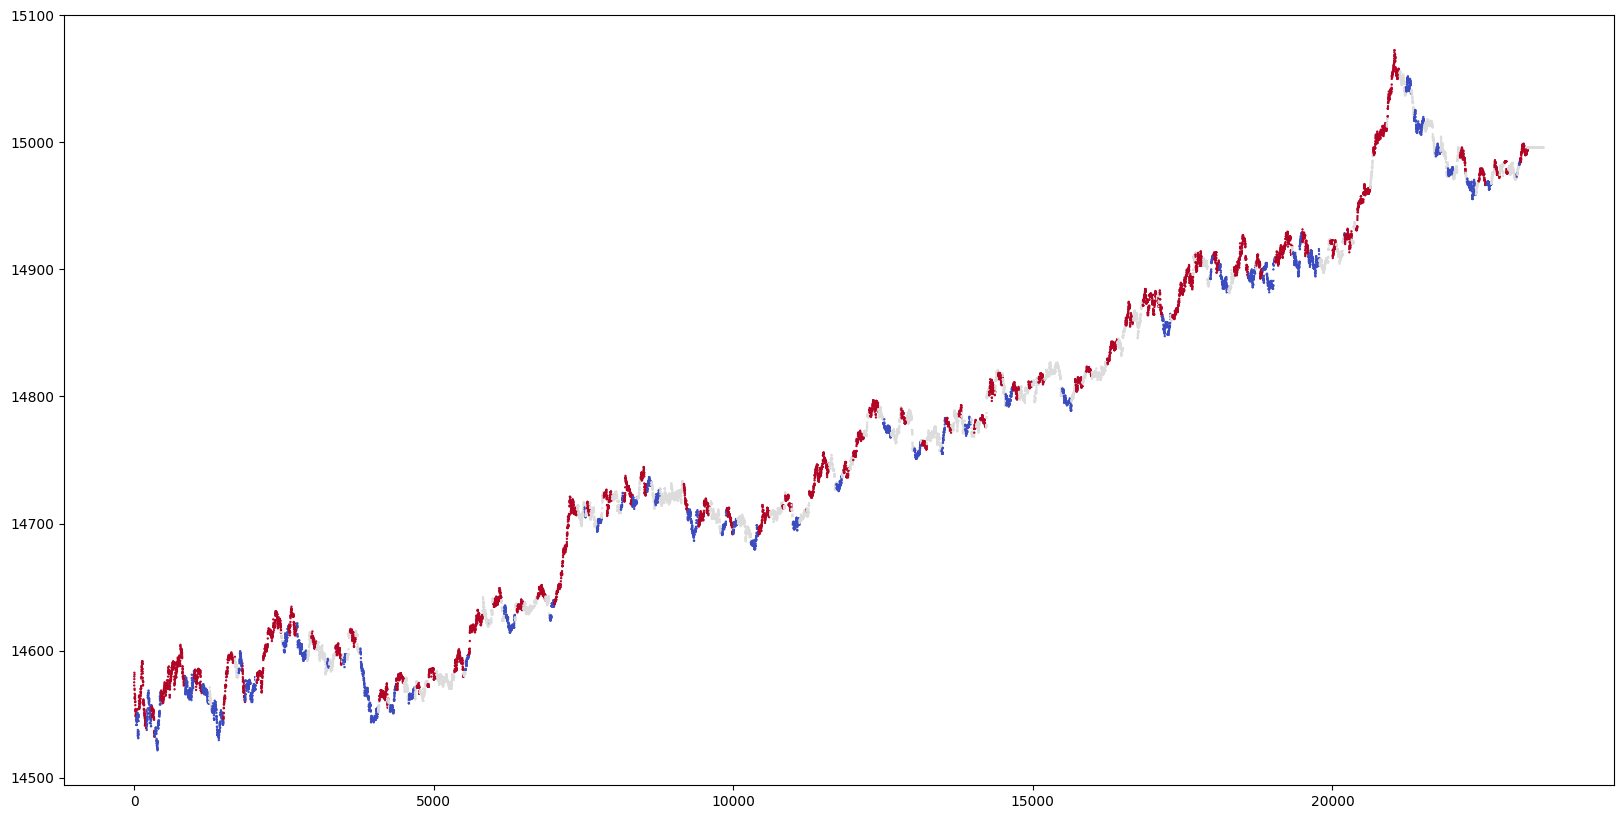

In [74]:
smoothed_pred = []

for i in range(len(pred)):
    if i < 100:
        smoothed_pred.append(pred[i])
    else:
        smoothed_pred.append(np.bincount(pred[i-100:i]).argmax())

pred = np.array(smoothed_pred)

plt.figure(figsize=(20, 10))
plt.scatter(np.arange(len(midprice)), midprice, s=0.5, c=pred, cmap='coolwarm')

In [86]:
midprice, ask1, bid1 = example_day.get_price()
signal = pred

In [87]:
# fee = 0.003 / 100
# position = 0
# cash = 0
# balance = 0

# position_list = []
# balance_list = []
# time_delay = 0
# long_patience = 0
# short_patience = 0
# patience_threshold = 5

# wait = 5
# for i in range(len(signal) - time_delay):
#     if wait > 0:
#         wait -= 1
#         continue
        
#     if signal[i] == 2:
#         long_patience += 1
#         short_patience = 0
#     elif signal[i] == 0 and (position == 0 or position == 1):
#         short_patience += 1
#         long_patience = 0
    
#     if long_patience > patience_threshold and (position == 0 or position == -1):
#         long_patience = 0
#         short_patience = 0
#         position_change = 1
#         trade_price = ask1[i+time_delay]
#     elif short_patience > patience_threshold and (position == 0 or position == 1):
#         short_patience = 0
#         long_patience = 0   
#         position_change = -1
#         trade_price = bid1[i+time_delay]
#     else:
#         position_change = 0
    
#     if position_change == 1:
#         cash -= trade_price
#         cash -= trade_price * fee
#         position += 1
#         print(f"{i}: Buy at {trade_price}, cash: {cash}, position: {position}")
#     elif position_change == -1:
#         cash += trade_price
#         cash -= trade_price * fee
#         position -= 1
#         print(f"{i}: Sell at {trade_price}, cash: {cash}, position: {position}")
    
#     balance = cash + position * midprice[i]
#     position_list.append(position)
#     balance_list.append(balance)
    

In [88]:
fee = 0.003 / 100
position = 0
cash = 0
balance = 0

position_list = []
balance_list = []
time_delay = 0
long_patience = 0
short_patience = 0
patience_threshold = 5
wait = 5
for i in range(len(signal) - time_delay):
    if wait > 0:
        wait -= 1
        continue
        
    if signal[i] == 2 and (position == 0 or position == -1):
        long_patience += 1
        short_patience = 0
    elif signal[i] == 0 and (position == 0 or position == 1):
        short_patience += 1
        long_patience = 0
    
    if long_patience > patience_threshold and (position == 0 or position == -1):
        long_patience = 0
        short_patience = 0
        position_change = 1
        trade_price = ask1[i+time_delay]
    elif short_patience > patience_threshold and (position == 0 or position == 1):
        short_patience = 0
        long_patience = 0   
        position_change = -1
        trade_price = bid1[i+time_delay]
    else:
        position_change = 0
    
    if position_change == 1:
        cash -= trade_price
        cash -= trade_price * fee
        position += 1
        print(f"{i}: Buy at {trade_price}, cash: {cash}, position: {position}")
    elif position_change == -1:
        cash += trade_price
        cash -= trade_price * fee
        position -= 1
        print(f"{i}: Sell at {trade_price}, cash: {cash}, position: {position}")
    
    balance = cash + position * midprice[i]
    position_list.append(position)
    balance_list.append(balance)
    

10: Buy at 14566, cash: -14566.43698, position: 1
38: Sell at 14538, cash: -28.873120000000405, position: 0
44: Sell at 14541, cash: 14511.69065, position: -1
81: Buy at 14568, cash: -56.74638999999954, position: 0
87: Buy at 14558, cash: -14615.18313, position: 1
212: Sell at 14538, cash: -77.61926999999943, position: 0
218: Sell at 14544, cash: 14465.94441, position: -1
296: Buy at 14557, cash: -91.49229999999994, position: 0
302: Buy at 14551, cash: -14642.92883, position: 1
351: Sell at 14532, cash: -111.36479000000074, position: 0
357: Sell at 14536, cash: 14424.199129999999, position: -1
453: Buy at 14567, cash: -143.23788000000093, position: 0
459: Buy at 14567, cash: -14710.67489, position: 1
855: Sell at 14563, cash: -148.11178000000024, position: 0
861: Sell at 14568, cash: 14419.451179999998, position: -1
1009: Buy at 14582, cash: -162.98628000000178, position: 0
1015: Buy at 14586, cash: -14749.42386, position: 1
1141: Sell at 14566, cash: -183.8608400000008, position: 0
11

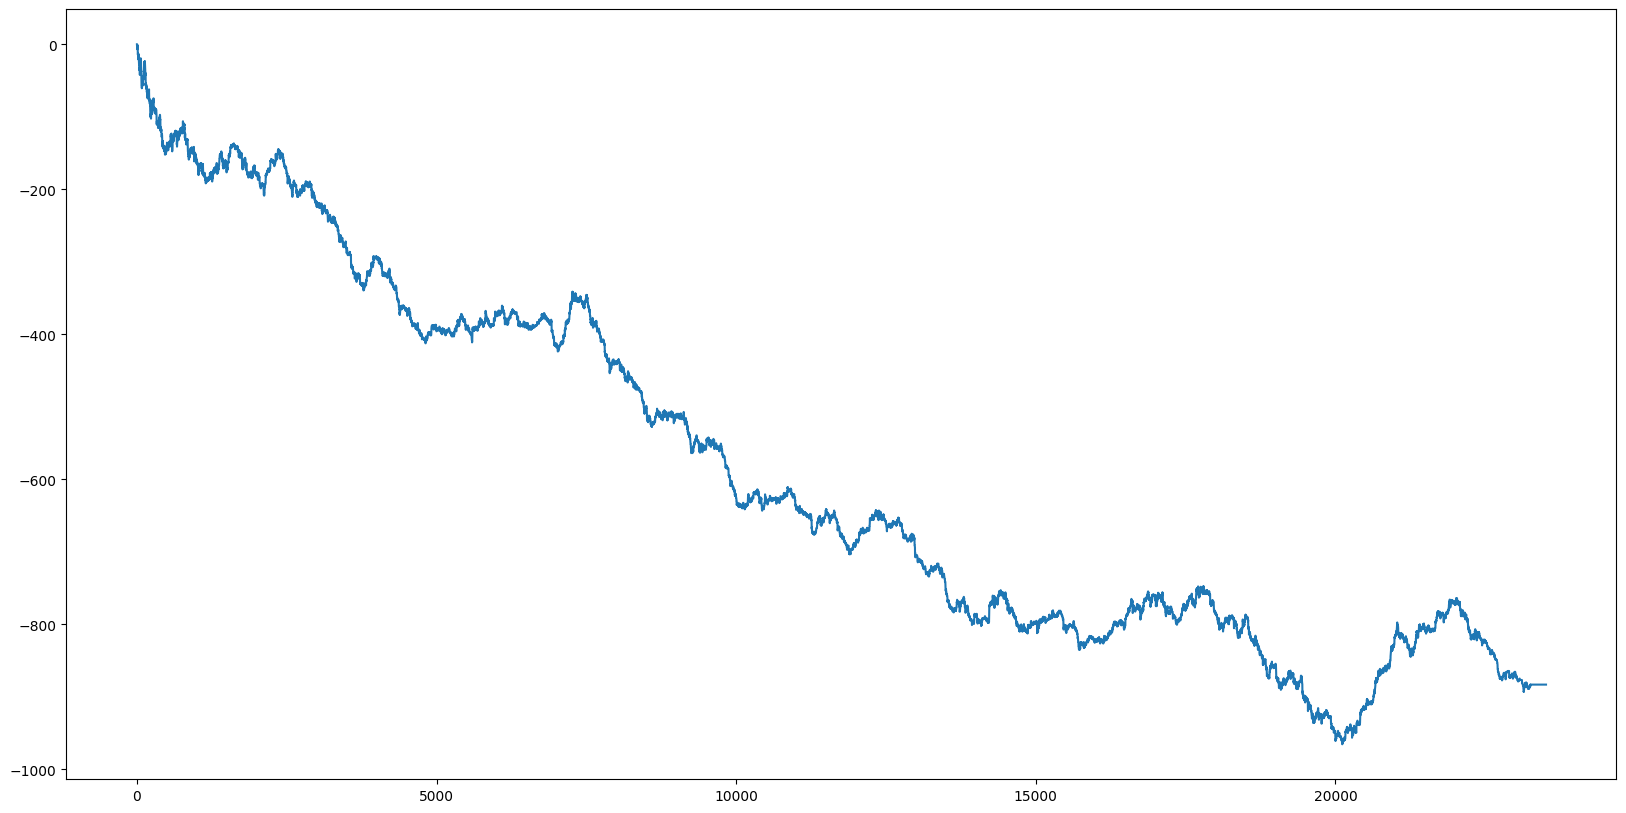

In [89]:
plt.figure(figsize=(20, 10))
plt.plot(balance_list)

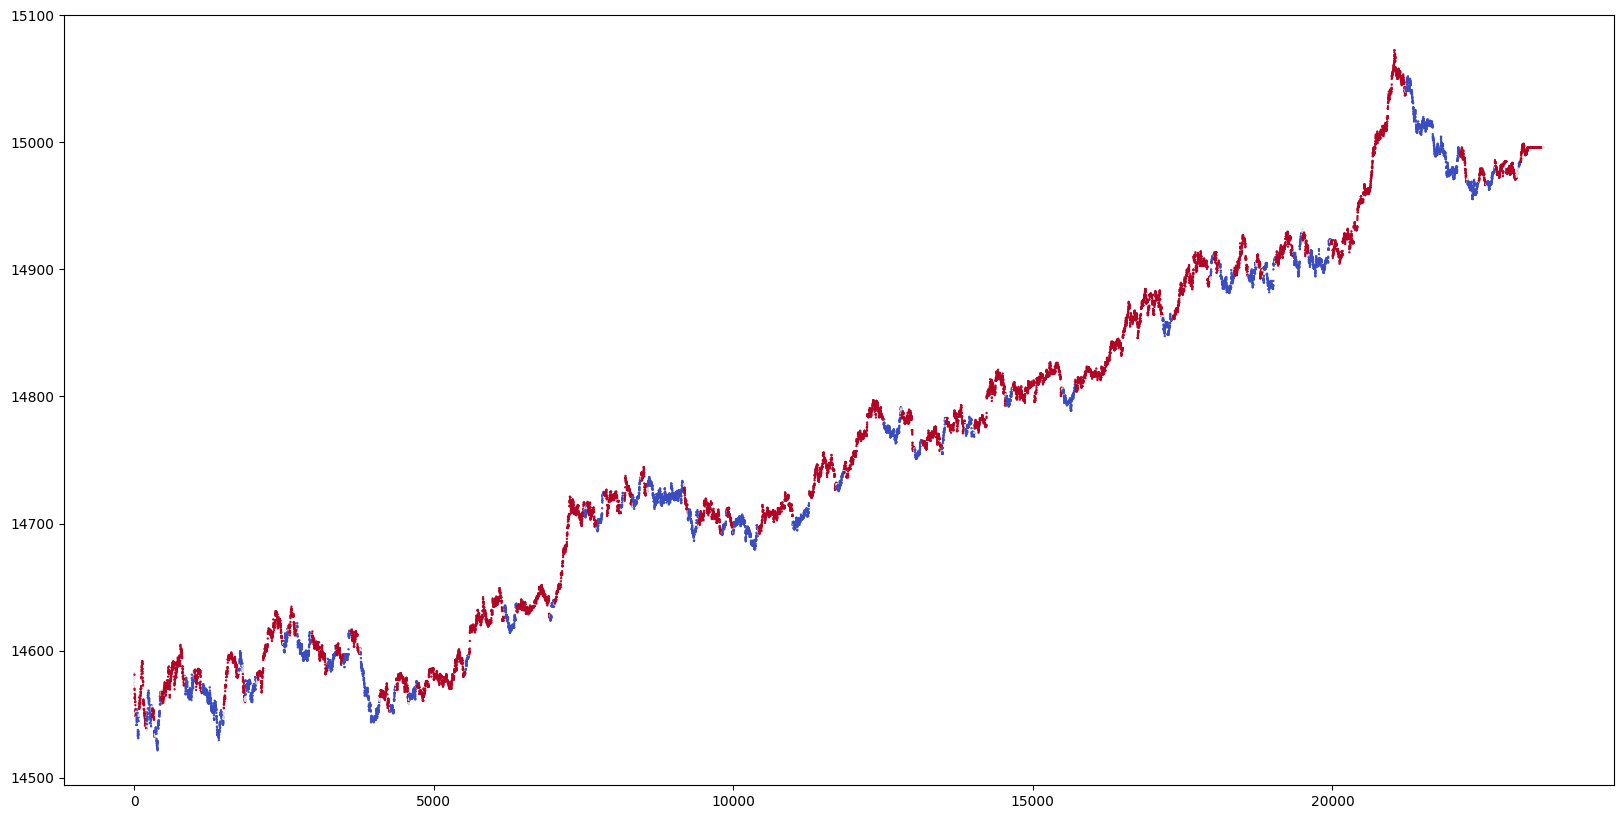

In [90]:
plt.figure(figsize=(20, 10))
plt.scatter(np.arange(len(midprice)), midprice, s=0.5, c=position_list +[0,0,0,0,0], cmap='coolwarm')
plt.show()

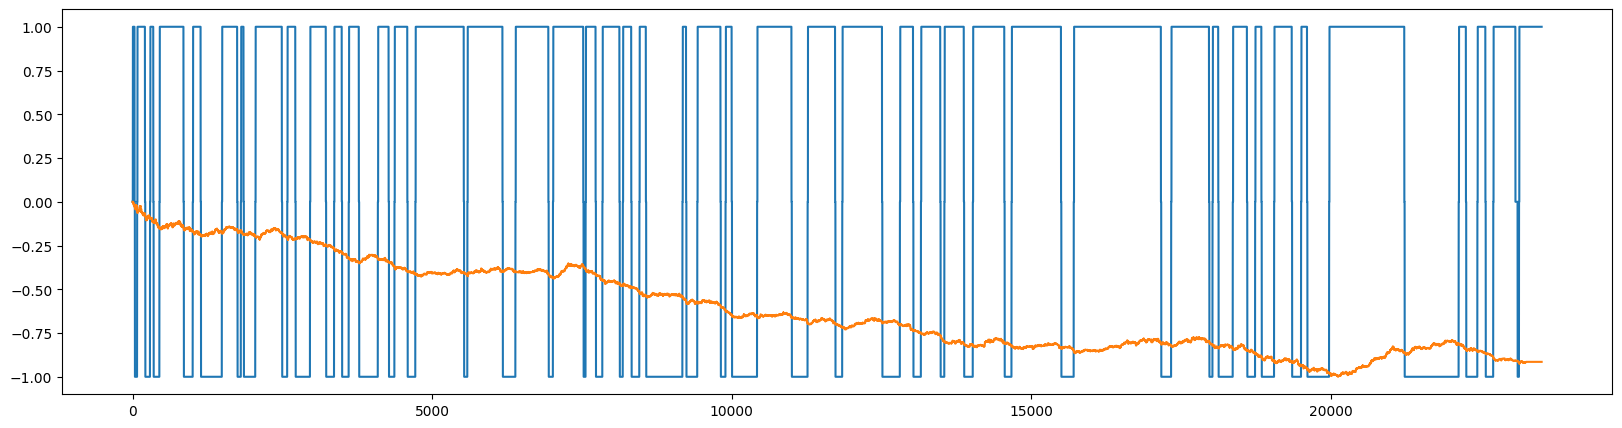

In [91]:
plt.figure(figsize=(20, 5))
plt.plot(position_list)
plt.plot(np.array(balance_list)/np.max(np.abs(balance_list)))
